In [1]:
import numpy as np
import os

output_folder = "generated-embeddings"
lables_file = "lables.npy"
encodings_file = "encodings.npy"

In [2]:
lables = np.load(os.path.join(output_folder, lables_file))
encodings = np.load(os.path.join(output_folder, encodings_file))

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score


In [4]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import pickle

In [7]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(encodings,
                                                        lables, 
                                                        test_size=0.33)
def train_classifier(encodings, lables, save_to="classifier.pkl"):
    
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    svc = SVC(kernel='linear', probability=True)

    knn.fit(X_train, y_train)
    svc.fit(X_train, y_train)

    acc_knn = accuracy_score(y_test, knn.predict(X_test))
    acc_svc = accuracy_score(y_test, svc.predict(X_test))

    print('KNN accuracy = %f, SVM accuracy = %f'  % (acc_knn, acc_svc ))
    with open(save_to, 'wb') as clf:
        pickle.dump(knn, clf)
    return knn, svc

knn, svc = train_classifier(encodings, lables)

KNN accuracy = 0.575758, SVM accuracy = 0.757576


In [8]:
print(knn.predict_proba([X_test[0]]), y_test[0], lables[0])
svc.predict_proba([X_test[1]])

[[1. 0.]] 1 0


array([[0.54098334, 0.45901666]])

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline 
plt.rcParams["figure.figsize"] = (15, 9)
import cv2, os, face_recognition, time
cv2.__version__

'4.1.0'

In [10]:
import os
import cv2
import face_recognition
import time
import align
import model

class Face:
    modelDir = 'models'
    dlibModelDir = os.path.join(modelDir, 'dlib')
    predictor = os.path.join(dlibModelDir, "shape_predictor_68_face_landmarks.dat")

    def __init__(self, baseImage, face_location, identity="UNKNOWN"):
        self.base = baseImage
        self.location = face_location
        self.identity = identity
        self.image = self._getFace()
        self._aligned = False


    def _getFace(self):
        top, right, bottom, left = self.location
        crop_img = self.base.image[top:bottom, left:right]
        return crop_img

    def save(self, path=''):
        _imageBaseName, _imageExt = os.path.splitext(self.base.imagePath)
        fileName = _imageBaseName.split('/')[-1] + "_face_" + str(
            time.time()) + _imageExt.lower()
        name = os.path.join(path, fileName)
        cv2.imwrite(name, self.image)
    
    def align(self):
        # Align the face. Input format of the face is Dlib(rgb)
        # AlignDlib is a wrapper on top of dlib, to help align the face landmarks.
        #   CMU wrote the AlignDlib.
        # TODO: Check if needed any modification for my usecase.
        if self._aligned:
            return
        alignment = align.AlignDlib(self.predictor)

        self.image = alignment.align(
            96,
            self.image,
            alignment.getLargestFaceBoundingBox(self.image),
            landmarkIndices=align.AlignDlib.OUTER_EYES_AND_NOSE)

    def getEncodings(self):
        return face_recognition.face_encodings(self.image, [self.location])

class Image:
    def __init__(self, path):
        self.imagePath = path
        self.image = cv2.imread(self.imagePath)
        self.faces = list()
        self._faceLocations = None

    def resize(self, pixelWidth=1000.0):
        # Resizing image frp pyimage search
        # https://www.pyimagesearch.com/2014/01/20/basic-image-manipulations-in-python-and-opencv-resizing-scaling-rotating-and-cropping/

        # we need to keep in mind aspect ratio so the image does
        # not look skewed or distorted -- therefore, we calculate
        # the ratio of the new image to the old image
        r = pixelWidth / self.image.shape[1]
        dim = (int(pixelWidth), int(self.image.shape[0] * r))

        # perform the actual resizing of the image and show it
        cv2.resize(self.image, dim, interpolation=cv2.INTER_AREA)

    def valid(self):
        if self.image is None or len(self.image.shape) < 3 or len(
                self.image) == 0:
            return False

        return True

    def _getFaceLocations(self):
        return face_recognition.face_locations(self.image)

    def detectFaces(self, resize=False):
        if resize:
            self.resize()
        if not self.valid():
            return
        self._faceLocations = self._getFaceLocations()

        for face_location in self._faceLocations:
            self.faces.append(Face(self, face_location))

    def drawBoundingBoxes(self):
        for face_location in self._faceLocations:
            top, right, bottom, left = face_location
            cv2.rectangle(self.image, (left, top), (right, bottom),
                          (0, 0, 255), 9)

    def saveFaces(self, path='data/faces'):
        for face in self.faces:
            face.save(path)


Using TensorFlow backend.


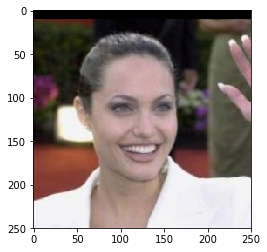

In [11]:

imagePath = 'data/photos/Angelina_Jolie/Angelina_Jolie_0001.jpg'
def shimg(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image = Image(imagePath)
shimg(image.image)

In [12]:
image.detectFaces()

In [13]:
!ls data/faces

Alexandra_Jackson     Angelina_Jolie        Arnold_Schwarzenegger
Amy_Gale              Ariel_Sharon          Atal_Bihari_Vajpayee


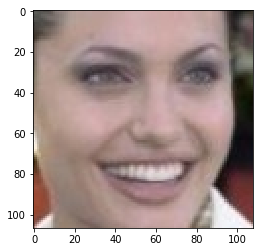

In [14]:
shimg(image.faces[0].image)

In [15]:
from imutils import paths

In [40]:
imgBaseDir = 'data/photos'
imagePaths = list(paths.list_images(imgBaseDir))
len(imagePaths)

150

In [41]:
knownEncodings = list()
knownNames = list()
import os, shutil
for (i, imagePath) in enumerate(imagePaths):
    # extract the person name from the image path
    name = imagePath.split(os.path.sep)[-2]

    image = Image(imagePath)
    image.detectFaces()
    if len(image.faces) == 0 or len(image.faces)>1:
        continue
    try:
        image.faces[0].align()
        encodings = image.faces[0].getEncodings()
    except Exception as e:
        print("[ERROR] Unable to process name {} image {}/{}".format(imagePath, i + 1,len(imagePaths)))        
    print("[INFO] processing name {} image {}/{}".format(imagePath, i + 1,len(imagePaths)))
    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)
        

[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0019.jpg image 1/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0018.jpg image 2/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0020.jpg image 3/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0008.jpg image 4/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0009.jpg image 5/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0013.jpg image 6/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0007.jpg image 7/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0006.jpg image 8/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0012.jpg image 9/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0010.jpg image 11/150
[INFO] processing name data/photos/Angelina_Jolie/Angelina_Jolie_0011.jpg image 12/150
[INFO] processing name data/photos/Angelina_Jolie/An

[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0028.jpg image 98/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0029.jpg image 99/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0015.jpg image 100/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0001.jpg image 101/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0017.jpg image 102/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0003.jpg image 103/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0002.jpg image 104/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0016.jpg image 105/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0059.jpg image 106/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0071.jpg image 107/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0065.jpg image 108/150
[INFO] processing name data/photos/Ariel_Sharon/Ariel_Sharon_0070.jpg image 11

In [42]:
# dump the facial encodings + names to disk
import pickle
print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
f = open("encodings.pkl", "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] serializing encodings...


In [125]:
fr_im0_face_enc = face_recognition.face_encodings(image.image, [image.faces[0].location])

In [138]:
face_recognition.compare_faces(fr_im0_face_enc, knownEncodings[0])

[False]

In [45]:
import pickle
with open('encodings.pkl', 'rb') as e:
    data = pickle.load(e)

In [169]:
len(data['encodings'])
# data['names']
print(len(data['encodings']), len(data['names']))
print(len(data['encodings'][0]))
! ls data/photos

143 143
128
Alexandra_Jackson     Angelina_Jolie        Arnold_Schwarzenegger
Amy_Gale              Ariel_Sharon          Atal_Bihari_Vajpayee


In [49]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

y_pred = KMeans(n_clusters=6).fit_predict(data['encodings'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

targets = np.array(data['names'])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

X_train, X_test, y_train, y_test = train_test_split(data['encodings'], data['names'])

knn = KNeighborsClassifier(n_neighbors=6, algorithm='ball_tree',  weights='distance')

knn.fit(X_train, y_train)
acc_knn = accuracy_score(y_test, knn.predict(X_test))

acc_knn

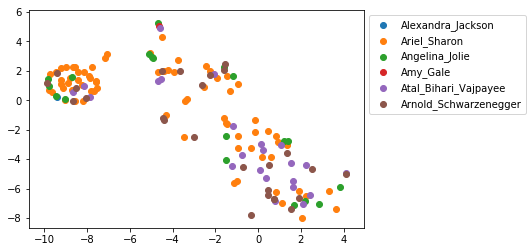

In [51]:
from sklearn.manifold import TSNE

X = TSNE(n_components=2).fit_transform(data['encodings'])

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X[idx, 1], X[idx, 0], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [142]:
from sklearn.cluster import DBSCAN
from imutils import build_montages
print("[INFO] clustering...")
clt = DBSCAN(metric="euclidean", n_jobs=4)
clt.fit(data['encodings'])

[INFO] clustering...


DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=4, p=None)

In [143]:
labelIDs = np.unique(clt.labels_)
labelIDs

array([0])